<a href="https://colab.research.google.com/github/SevioStanton/ai_games/blob/master/Battlezone_DeepQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Dependencies**

In [1]:

import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import os # for creating directories

Using TensorFlow backend.


**Set Hyperparameters**

In [2]:
env = gym.make('BattleZone-v0') # initialise environment

In [3]:
state_size = env.observation_space.shape[0]
state_size

#The shape attribute for numpy arrays returns the dimensions of the array. 
#If Y has n rows and m columns, then Y.shape is (n,m). So Y.shape[0] is n
#so, number of rowes in observation space is 210 for Battlezone.
#not sure what is included in those rows.
#for cartpole, the rows were for cart velocity, cart position, pole position, and pole angular velocity


210

In [4]:
action_size = env.action_space.n
action_size

18

In [5]:
env.unwrapped.get_action_meanings()

##could posibly remove up and down from actions to eliminate tank movement.

['NOOP',
 'FIRE',
 'UP',
 'RIGHT',
 'LEFT',
 'DOWN',
 'UPRIGHT',
 'UPLEFT',
 'DOWNRIGHT',
 'DOWNLEFT',
 'UPFIRE',
 'RIGHTFIRE',
 'LEFTFIRE',
 'DOWNFIRE',
 'UPRIGHTFIRE',
 'UPLEFTFIRE',
 'DOWNRIGHTFIRE',
 'DOWNLEFTFIRE']

In [6]:
batch_size = 32

**Info on batch optimal batch sizes**

From the recent Deep Learning book by Goodfellow et al., chapter 8:

Minibatch sizes are generally driven by the following factors:

Larger batches provide a more accurate estimate of the gradient, but with less than linear returns.
Multicore architectures are usually underutilized by extremely small batches. This motivates using some absolute minimum batch size, below which there is no reduction in the time to process a minibatch.
If all examples in the batch are to be processed in parallel (as is typically the case), then the amount of memory scales with the batch size. For many hardware setups this is the limiting factor in batch size.
Some kinds of hardware achieve better runtime with speciﬁc sizes of arrays. Especially when using GPUs, it is common for power of 2 batch sizes to offer better runtime. Typical power of 2 batch sizes range from 32 to 256, with 16 sometimes being attempted for large models.
Small batches can offer a regularizing effect (Wilson and Martinez, 2003), perhaps due to the noise they add to the learning process. Generalization error is often best for a batch size of 1. Training with such a small batch size might require a small learning rate to maintain stability because of the high variance in the estimate of the gradient. The total runtime can be very high as a result of the need to make more steps, both because of the reduced learning rate and because it takes more steps to observe the entire training set.
Which in practice usually means "in powers of 2 and the larger the better, provided that the batch fits into your (GPU) memory".

You might want also to consult several good posts here in Stack Exchange:

Tradeoff batch size vs. number of iterations to train a neural network
Selection of Mini-batch Size for Neural Network Regression
How large should the batch size be for stochastic gradient descent?
Just keep in mind that the paper by Keskar et al. 'On Large-Batch Training for Deep Learning: Generalization Gap and Sharp Minima', quoted by several of the posts above, has received some objections by other respectable researchers of the deep learning community.

Hope this helps...

UPDATE (Dec 2017): There is a new paper by Yoshua Bengio & team, Three Factors Influencing Minima in SGD (Nov 2017); it is worth reading in the sense that it reports new theoretical & experimental results on the interplay between learning rate and batch size.

In [14]:
n_episodes = 200 #number of games we want to play

#could probably optimize for some diminishing returns threshold.
#doing so should also eliminate overfitting.

In [15]:
output_dir = 'model_output/battlezone/'

In [16]:
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

  #if file location does not exist, make it

**Define Agent**

In [17]:
class DQNAgent:
  def __init__(self, state_size, action_size):
    self.state_size = state_size
    self.action_size = action_size
    self.memory = deque(maxlen=2000)
    #deque is a double-ended que which acts like a list, but elements can be added
    #or removed from either end

    self.gamma = 0.95
    #decay/discount rate: enables agent to take into account future actions
    #in addition to the immediate ones, but gives less credence to future rwards
    #the farther out they are.

    self.epsilon = 1.0
    #exploration rate: the initial probability of exploration
    #will decrease based on the epsilon decay rate

    self.epsilon_decay = 0.995
    #decrease the number of random explorations by 0.5% every time step
    #decay rate is multiplied to epsilon later ************************

    self.epsilon_min = 0.001
    #minimum amount of random exploratory probability

    self.learning_rate = 0.001
    #rate at which neural network adjusts model parameters via
    #stochastic gradient descent

    self.model = self._build_model() #private method
    #should only be accessible from within the class


  
  def _build_model(self):
    #neural net to approximate Q-value Function:
    model = Sequential()

    model.add(Dense(32, activation='relu', input_dim=self.state_size))
    #first hidden layer
    #states are the input, 210 of them

    model.add(Dense(32, activation = 'relu'))
    #second hidden layer

    model.add(Dense(self.action_size, activation = 'linear'))
    #18 actions, so there should be 18 output neurons

    model.compile(loss='mse', optimizer = Adam(lr = self.learning_rate))
    #consider other loss functions https://keras.io/api/losses/ to replace mse

    return model



  def remember(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))
    #appends list of previous experiences
    #allows for retraining later



  def train(self, batch_size):
    #method that trains neural network with experiences sampled from memory

    minibatch = random.sample(self.memory, batch_size)
    #sample a minibatch from memory

    for state, action, reward, next_state, done in minibatch:
      #xtract data for each minibatch sample
      
      #if done
      target = reward
      #if done, which is a boolean describing whether or not the game is done,
      #then target equals reward

      if not done:
        target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
        #targe is equal to reward plus discount rate times the maximum target Q based on future reward

      target_f = self.model.predict(state)
      #approximately map current state to future discounted reward

      target_f[0][action] = target
      #target_f is an arary of arrays
      #target is assigned to the action-nth index in the 0th array of target_f

      self.model.fit(state, target_f, epochs = 1, verbose = 0)
      #single epoch of training with x=state, y=target_f; fit decreases loss between
      #target_f and y_hat

    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay
      #reduces epsilon by 0.5% of itself (if decay = 0.995)
      #until min threshold is reached/surpassed



  def act(self, state):
    if np.random.rand() <= self.epsilon:
      #if acting randomly, take random action
      #random number generated from 0 to 1

      return random.randrange(self.action_size)
      #returns random choice from range of action_size (0:18)

    act_values = self.model.predict(state)
    #if not acting randomly, predict reward value based on current state

    return np.argmax(act_values[0])
    #pick the action that will give the highest reward
    #maycause a problem as in battlezone and telescopes
    #simultaneous actionsa are possible. ie, move and shoot or move up and left

  

  def save(self, name):
    self.model.save_weights(name)

  def load(self, name):
    self.model.load_weights(name)


**Interact with Environment**

In [18]:
agent = DQNAgent(state_size, action_size) #initialize agent

In [19]:
episode_array = []
episode_counter = 0
time_score_array = []

for e in range(n_episodes):
  #iterate over of episodes of the game

  state = env.reset()
  #reset state at start of each new episode of the game

  state = np.reshape(state, [480, state_size])

  done = False

  time = 0
  #time represents a frame of the episode
  #may need to edit this


  while not done:
    #env.render()
    
    action = agent.act(state)
    #choose from set of 18 actions

    next_state, reward, done, _ = env.step(action)
    #agent interacts with env, gets feedback; 210 state data points

    reward = reward if not done else -10
    #may not translate well from cartpole to battlezone.
    #I guess it may reward survival

    next_state = np.reshape(next_state, [480, state_size])

    agent.remember(state, action, reward, next_state, done)
    #remember the previous timestep's state, actions, reward, etc.

    state = next_state
    #set "current state" for upcoming iteration to the current next state

    if done:
      #if episode ends:
      print("episode: {}/{}, score: {}, e: {:.2}".format(e, n_episodes-1, time, agent.epsilon))
      #print the epsisode's score (time) and agent's epsilon

      episode_counter+=1
      episode_array.append(episode_counter)

      time_score_array.append(time)

    time+=1


  if len(agent.memory) > batch_size:
    agent.train(batch_size)
    #train the agent by replaying the experiences of the episode

  if e % 10 == 0:
    agent.save(output_dir + "weights_" + '{:04d}'.format(e) + ".hdf5")

episode: 107/199, score: 1467, e: 0.58


KeyboardInterrupt: ignored

In [92]:
print(episode_array)
print(time_score_array)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [94]:
import matplotlib.pyplot as plt

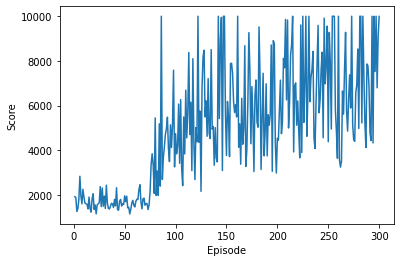

In [95]:
plt.plot(episode_array,time_score_array)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

In [123]:
def normalize_scores(score_input):
  data = np.copy(score_input)
  normalizing_factor = np.amax(score_input)
  print(data[0]/np.amax(score_input))
  print(normalizing_factor)
  normed = []
  for score in range(len(data)):
    print(data[score]/np.amax(score_input))
    normed.append(data[score]/np.amax(score_input))
    #print(normed)
  return normed

normalized_time_scores = normalize_scores(time_score_array)
print(normalized_time_scores)
print(normalized_time_scores[0])


0.1921192119211921
9999
0.1921192119211921
0.18931893189318932
0.1269126912691269
0.1391139113911391
0.17941794179417941
0.28372837283728375
0.19621962196219622
0.16001600160016002
0.22542254225422542
0.18991899189918993
0.1641164116411641
0.16081608160816083
0.15861586158615862
0.13781378137813782
0.19061906190619063
0.13901390139013903
0.12321232123212321
0.18271827182718273
0.20552055205520553
0.13551355135513551
0.1555155515551555
0.11551155115511551
0.1557155715571557
0.16031603160316032
0.16521652165216522
0.2376237623762376
0.148014801480148
0.23142314231423142
0.1498149814981498
0.19511951195119512
0.1397139713971397
0.24382438243824384
0.1641164116411641
0.1398139813981398
0.13731373137313732
0.1491149114911491
0.1626162616261626
0.16061606160616063
0.14411441144114412
0.18021802180218022
0.15131513151315132
0.23222322232223222
0.1348134813481348
0.1318131813181318
0.1718171817181718
0.18021802180218022
0.15061506150615062
0.16111611161116113
0.15801580158015802
0.196319631963

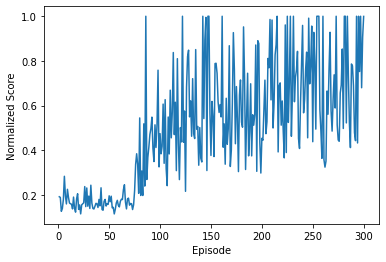

In [124]:
plt.plot(episode_array, normalized_time_scores)
plt.ylabel('Normalized Score')
plt.xlabel('Episode')
plt.show()

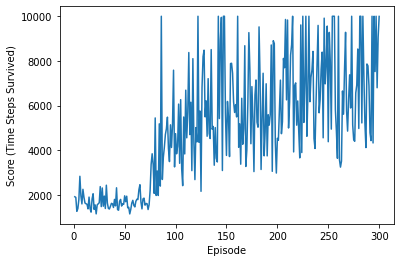

In [125]:
plt.plot(episode_array,time_score_array, scaley=True)
plt.ylabel('Score (Time Steps Survived)')
plt.xlabel('Episode')
plt.show()

In [105]:
from sklearn import preprocessing
import numpy as np

data = np.copy(time_score_array)
print("Data = ", data)

# normalize the data attributes
normalized = preprocessing.normalize(data)
print("Normalized Data = ", normalized)

Data =  [1921 1893 1269 1391 1794 2837 1962 1600 2254 1899 1641 1608 1586 1378
 1906 1390 1232 1827 2055 1355 1555 1155 1557 1603 1652 2376 1480 2314
 1498 1951 1397 2438 1641 1398 1373 1491 1626 1606 1441 1802 1513 2322
 1348 1318 1718 1802 1506 1611 1580 1963 1698 1946 1426 1449 1153 1358
 1639 1761 1535 1467 1717 1809 1796 2239 2459 1682 1378 1826 1860 1544
 1620 1609 1349 1563 2200 3373 3845 3359 2073 5448 1978 3073 1978 5184
 2399 9999 2693 3690 4146 4708 4969 5484 4081 3495 5140 4126 5144 7585
 3257 4745 3843 4180 6067 3418 6267 3177 2417 5490 3837 6690 4558 5701
 8375 4702 6151 3090 8101 4332 2688 5016 4376 9999 4361 5758 2164 6817
 8192 8481 5496 6211 4628 7206 4749 4526 8507 4942 5068 3332 5017 3647
 3478 9999 5421 8934 9949 3095 9999 9999 5641 3770 6186 5473 3719 7881
 7895 7447 6167 5693 6045 5493 9999 4138 5182 3378 6328 4271 4974 8680
 3276 3998 6085 9266 7606 4294 6851 5439 3047 6466 7147 5258 5034 9522
 7257 3141 5455 7448 3752 4816 6977 3750 5589 5126 5603 8713 3058 890

ValueError: ignored

In [108]:
print(time_score_array[0]/np.amax(time_score_array))

0.1921192119211921


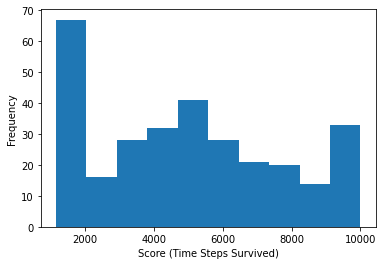

In [126]:
plt.hist(time_score_array)
plt.xlabel('Score (Time Steps Survived)')
plt.ylabel('Frequency')
plt.show()

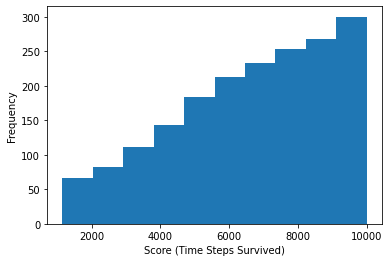

In [127]:
plt.hist(time_score_array, cumulative = True)
plt.xlabel('Score (Time Steps Survived)')
plt.ylabel('Frequency')
plt.show()

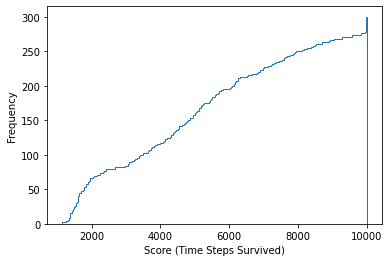

In [129]:
plt.hist(time_score_array, cumulative = True, histtype = 'step', bins=500)
plt.xlabel('Score (Time Steps Survived)')
plt.ylabel('Frequency')
plt.show()

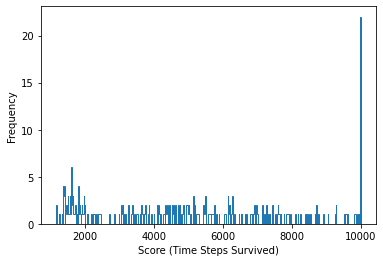

In [130]:
plt.hist(time_score_array, histtype = 'step', bins=500)
plt.xlabel('Score (Time Steps Survived)')
plt.ylabel('Frequency')
plt.show()

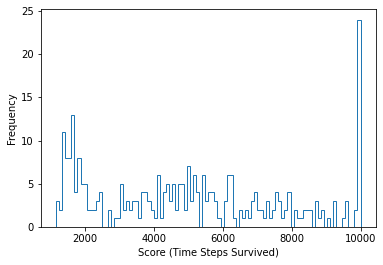

In [133]:
plt.hist(time_score_array, histtype = 'step', bins = 100)
plt.xlabel('Score (Time Steps Survived)')
plt.ylabel('Frequency')
plt.show()

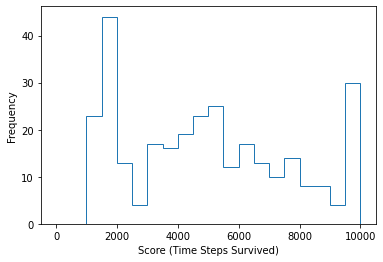

In [144]:
def bin_width(width_int, data_array):
  bin_size = []
  num_of_bins = int(round(np.amax(data_array)/width_int))
  for i in range(num_of_bins+1):
    bin_size.append(width_int*i)
  return bin_size

plt.hist(time_score_array, histtype = 'step', bins= bin_width(500, time_score_array))
plt.xlabel('Score (Time Steps Survived)')
plt.ylabel('Frequency')
plt.show()

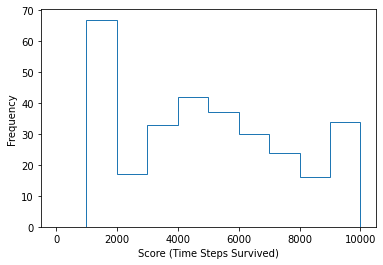

In [145]:
plt.hist(time_score_array, histtype = 'step', bins= bin_width(1000, time_score_array))
plt.xlabel('Score (Time Steps Survived)')
plt.ylabel('Frequency')
plt.show()

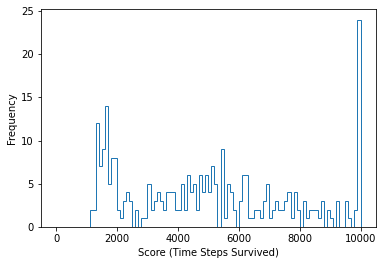

In [146]:


plt.hist(time_score_array, histtype = 'step', bins= bin_width(100, time_score_array))
plt.xlabel('Score (Time Steps Survived)')
plt.ylabel('Frequency')
plt.show()

In [147]:
count = 0
for i in range(len(time_score_array)):
  if time_score_array[i] >= 8000:
    count+=1
print(count)

print(count/n_episodes)

50
0.16666666666666666


In [148]:
count = 0
for i in range(len(time_score_array)):
  if time_score_array[i] >= 9000:
    count+=1
print(count)

print(count/n_episodes)

34
0.11333333333333333


In [149]:
count = 0
for i in range(len(time_score_array)):
  if time_score_array[i] >= 9999:
    count+=1
print(count)

print(count/n_episodes)

21
0.07


In [5]:
from keras.models import Sequential
from keras.layers import Dense, Activation
model = Sequential ([
                     Dense(5,input_shape=(3,), activation = 'relu'),
                     Dense(3, activation = 'softmax')
])

In [8]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import imageio
%matplotlib inline
#img = np.expand_dims(imageio.imread('NN.PNG'), 0)
#plt.imshow(img[0])

help(ndimage)

Help on package scipy.ndimage in scipy:

NAME
    scipy.ndimage

DESCRIPTION
    Multi-dimensional image processing (:mod:`scipy.ndimage`)
    
    .. currentmodule:: scipy.ndimage
    
    This package contains various functions for multi-dimensional image
    processing.
    
    
    Filters
    
    .. autosummary::
       :toctree: generated/
    
       convolve - Multi-dimensional convolution
       convolve1d - 1-D convolution along the given axis
       correlate - Multi-dimensional correlation
       correlate1d - 1-D correlation along the given axis
       gaussian_filter
       gaussian_filter1d
       gaussian_gradient_magnitude
       gaussian_laplace
       generic_filter - Multi-dimensional filter using a given function
       generic_filter1d - 1-D generic filter along the given axis
       generic_gradient_magnitude
       generic_laplace
       laplace - n-D Laplace filter based on approximate second derivatives
       maximum_filter
       maximum_filter1d
       me

In [13]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")